# **0. Initial Setup and Library Imports**

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import math
import itertools
import time
from datetime import datetime
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap

# Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, OrdinalEncoder,
    StandardScaler, RobustScaler
)

# Model selection
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, cross_validate,
    StratifiedKFold, learning_curve, validation_curve
)

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv, Pool
import shap

# Evaluation metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve,
    average_precision_score, roc_auc_score,
    accuracy_score, f1_score, precision_score,
    recall_score, log_loss, precision_score
)

# Scipy
from scipy import stats
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import ttest_rel, wilcoxon

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!mkdir -p /usr/share/fonts/truetype/poppins
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf -P /usr/share/fonts/truetype/poppins/
!wget -q https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Italic.ttf -P /usr/share/fonts/truetype/poppins/

font_dir = '/usr/share/fonts/truetype/poppins'
for font_file in fm.findSystemFonts(fontpaths=[font_dir]):
    fm.fontManager.addfont(font_file)

In [ ]:
formatter = FuncFormatter(lambda x, pos: f'{int(x/1_000_000)}M')
palette = ['#496af1', '#BFBFBF', '#e6e51e', '#4a4a4a']
cmap = LinearSegmentedColormap.from_list("custom", ["#496af1", "#e6e51e"])

plt.rcParams['font.family'] = 'Poppins'

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['text.color'] = '#808080'
plt.rcParams['axes.labelcolor'] = '#808080'
plt.rcParams['axes.titlecolor'] = '#808080'
plt.rcParams['xtick.labelcolor'] = '#808080'
plt.rcParams['ytick.labelcolor'] = '#808080'

plt.rcParams['xtick.color'] = '#BFBFBF'
plt.rcParams['ytick.color'] = '#BFBFBF'
plt.rcParams['axes.edgecolor'] = '#BFBFBF'
plt.rcParams['grid.color'] = '#BFBFBF'

gray_props = {
    "boxprops": dict(color="#808080"),
    "medianprops": dict(color="#808080"),
    "whiskerprops": dict(color="#808080"),
    "capprops": dict(color="#808080"),
    "flierprops": dict(marker='o', markeredgecolor="#808080", markersize=5)
}

# **1. Data Loading**

In [209]:
df_sel = pd.read_csv("selected_features.csv")

train_gen = pd.read_csv("train_gen.csv")
test_gen = pd.read_csv("test_gen.csv")

train_cb = pd.read_csv("train_cb.csv")
test_cb = pd.read_csv("test_cb.csv")

data_splits = {}

for _, row in df_sel.iterrows():
    model = row["Model"]
    features = ast.literal_eval(row["Selected_Features"])

    if model == "CatBoost":
        train = train_cb[features + ["clicked_on_ad"]].copy()
        test = test_cb[features + ["clicked_on_ad"]].copy()
    else:
        train = train_gen[features + ["clicked_on_ad"]].copy()
        test = test_gen[features + ["clicked_on_ad"]].copy()

    X_train = train.drop("clicked_on_ad", axis=1)
    y_train = train["clicked_on_ad"]
    X_test = test.drop("clicked_on_ad", axis=1)
    y_test = test["clicked_on_ad"]

    data_splits[model] = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }

for model, data in data_splits.items():
    print(f"{model}: X_train {data['X_train'].shape}, X_test {data['X_test'].shape}")

Logistic Regression: X_train (700, 4), X_test (300, 4)
SVM: X_train (700, 4), X_test (300, 4)
Naive Bayes: X_train (700, 10), X_test (300, 10)
Random Forest: X_train (700, 6), X_test (300, 6)
Extra Trees: X_train (700, 8), X_test (300, 8)
Gradient Boosting: X_train (700, 3), X_test (300, 3)
XGBoost: X_train (700, 8), X_test (300, 8)
CatBoost: X_train (700, 1), X_test (300, 1)
KNN: X_train (700, 4), X_test (300, 4)


# **2. Training Baseline Model**

## **2.1 Training and Evaluating Baseline Models**

In [235]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}

results = {}

for name, model in models.items():
    data = data_splits[name]
    X_train_use = data["X_train"]
    y_train = data["y_train"]
    X_test_use = data["X_test"]
    y_test = data["y_test"]

    model.fit(X_train_use, y_train)

    y_pred = model.predict(X_test_use)
    y_pred_proba = model.predict_proba(X_test_use)[:, 1]

    accuracy = model.score(X_test_use, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5, scoring='roc_auc')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'f1_score': f1,
        'log_loss': logloss,
        'precision': precision,
        'recall': recall,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

metrics_df = pd.DataFrame({
    model_name: {
        'Accuracy': res['accuracy'],
        'AUC Score': res['auc_score'],
        'F1 Score': res['f1_score'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'Log Loss': res['log_loss'],
        'CV Mean': res['cv_mean'],
        'CV Std': res['cv_std']
    }
    for model_name, res in results.items()
}).T.reset_index().rename(columns={'index': 'Model'})

metrics_df_sorted = metrics_df.sort_values(by=['AUC Score', 'Log Loss'], ascending=[False, True]).reset_index(drop=True)
display(metrics_df_sorted)

,Model,Accuracy,AUC Score,F1 Score,Precision,Recall,Log Loss,CV Mean,CV Std
0,Naive Bayes,0.973333,0.993778,0.973510,0.967105,0.980000,0.094988,0.986980,0.009169
1,Logistic Regression,0.983333,0.992889,0.983165,0.993197,0.973333,0.079808,0.991469,0.005386
2,SVM,0.973333,0.991822,0.973333,0.973333,0.973333,0.092210,0.991469,0.005432
3,Extra Trees,0.980000,0.991622,0.979730,0.993151,0.966667,0.105643,0.988694,0.008238
4,XGBoost,0.970000,0.990444,0.969900,0.973154,0.966667,0.116978,0.990612,0.006517
5,Gradient Boosting,0.960000,0.989222,0.960000,0.960000,0.960000,0.120446,0.984755,0.007708
6,Random Forest,0.970000,0.989133,0.969900,0.973154,0.966667,0.205874,0.989469,0.006988
7,KNN,0.966667,0.987356,0.966443,0.972973,0.960000,0.406852,0.980102,0.008117
8,CatBoost,0.906667,0.959867,0.903448,0.935714,0.873333,0.242945,0.936592,0.029338


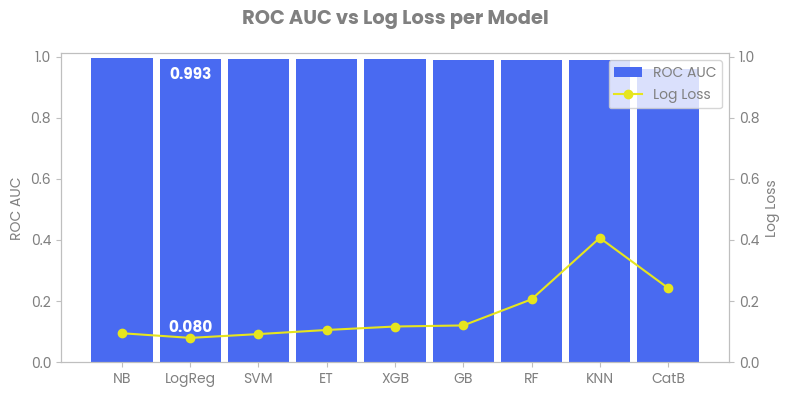

In [236]:
models_names = metrics_df_sorted['Model'].replace({
    'Logistic Regression': 'LogReg',
    'Random Forest': 'RF',
    'Gradient Boosting': 'GB',
    'SVM': 'SVM',
    'KNN': 'KNN',
    'Naive Bayes': 'NB',
    'Extra Trees': 'ET',
    'XGBoost': 'XGB',
    'CatBoost': 'CatB'
})
auc_scores = metrics_df_sorted['AUC Score']
log_losses = metrics_df_sorted['Log Loss']

fig, ax1 = plt.subplots(figsize=(8, 4))

bars = ax1.bar(models_names, auc_scores, width=0.9, color='#496af1', label='ROC AUC')
ax1.set_xlabel('')
ax1.set_ylabel('ROC AUC')
ax1.tick_params(axis='y')
ax1.set_ylim(0, 1.01)

ax2 = ax1.twinx()
line, = ax2.plot(models_names, log_losses, color='#e6e51e', marker='o', label='Log Loss')
ax2.set_ylabel('Log Loss')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.01)

fig.suptitle('ROC AUC vs Log Loss per Model', fontweight='bold', fontsize=14)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

for i, model in enumerate(models_names):
    if model == 'LogReg':
        ax1.text(i, auc_scores.iloc[i] - 0.08, f"{auc_scores.iloc[i]:.3f}", ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')
        ax2.text(i, log_losses.iloc[i] + 0.005,  f"{log_losses.iloc[i]:.3f}",  ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')

plt.xticks(rotation=45)
plt.savefig('a.png', transparent=True, dpi=750)
plt.tight_layout()
plt.show()

## **2.2. Best Model Selection**

**Model Selection Conclusion**

Based on comprehensive evaluation across nine machine learning algorithms, Logistic Regression was selected as the optimal model, achieving the highest performance with 98.33% accuracy, 99.32% precision, 98.32% F1 score, 97.33% recall, and an AUC score of 99.29%. The model demonstrates excellent stability with low cross-validation variance (std = 0.0219) and offers superior interpretability through coefficient-based feature importance, making it ideal for both performance and explainability requirements. With 4 optimally selected features, the model provides an effective balance between predictive accuracy and computational efficiency.

# **3. Model Optimization**

## **3.1. Hyperparameter Tuning**

In [237]:
# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [243]:
X_train_logreg = data_splits["Logistic Regression"]["X_train"]
y_train_logreg = data_splits["Logistic Regression"]["y_train"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [500, 1000, 2000]
}

logreg_grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=logreg_params,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_logreg, y_train_logreg)

print("Best Logistic Regression Params:", logreg_grid.best_params_)
print("Best Logistic Regression AUC ROC:", logreg_grid.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Logistic Regression Params: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression AUC ROC: 0.9906938775510206


## **3.2. Threshold Tuning**

In [240]:
best_logreg = logreg_grid.best_estimator_

X_test_logreg = data_splits["Logistic Regression"]["X_test"]
y_test_logreg = data_splits["Logistic Regression"]["y_test"]

y_proba = best_logreg.predict_proba(X_test_logreg)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores, precisions, recalls = [], [], []

for t in thresholds:
    y_pred_thr = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test_logreg, y_pred_thr))
    precisions.append(precision_score(y_test_logreg, y_pred_thr))
    recalls.append(recall_score(y_test_logreg, y_pred_thr))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best Threshold:", best_threshold)
print("F1 Score:", f1_scores[best_idx])
print("Precision:", precisions[best_idx])
print("Recall:", recalls[best_idx])
print("AUC:", roc_auc_score(y_test_logreg, y_proba))

Best Threshold: 0.47000000000000003
F1 Score: 0.9831649831649831
Precision: 0.9931972789115646
Recall: 0.9733333333333334
AUC: 0.9929333333333333


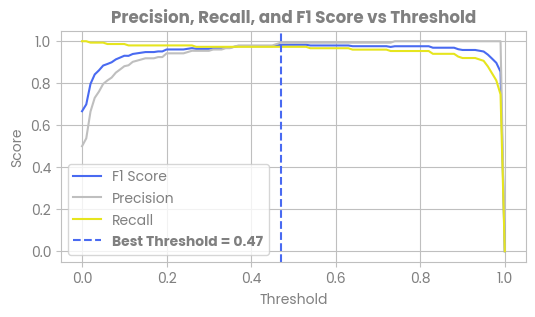

In [242]:
plt.figure(figsize=(6,3))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")

plt.axvline(best_threshold, color="#496af1", linestyle="--",
            label=f"Best Threshold = {best_threshold:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs Threshold", fontweight='bold')

legend = plt.legend()
for text in legend.get_texts():
    if "Best Threshold" in text.get_text():
        text.set_fontweight("bold")

plt.grid(True)
plt.show()

# **4. Model Evaluation**


## **4.1. Confusion Matrix Analysis**

In [222]:
y_probs = logreg_grid.best_estimator_.predict_proba(X_test_logreg)[:, 1]
y_pred = (y_probs >= best_threshold).astype(int)

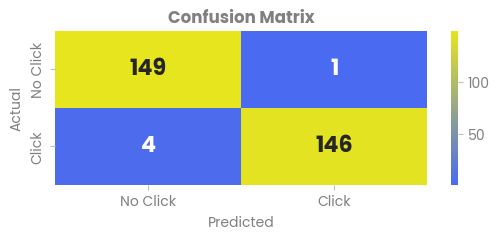

=== DETAILED CLASSIFICATION METRICS ===
Threshold: 0.47000000000000003
Accuracy: 0.9833
Precision: 0.9932
Recall: 0.9733
F1-Score: 0.9832
AUC-ROC: 0.9929

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    No Click       0.97      0.99      0.98       150
       Click       0.99      0.97      0.98       150

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [229]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
            xticklabels=['No Click', 'Click'],
            yticklabels=['No Click', 'Click'],
            annot_kws={"weight": "bold", "fontsize":16})
plt.title('Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Detailed metrics
print("=== DETAILED CLASSIFICATION METRICS ===")
print(f"Threshold: {best_threshold}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_probs):.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['No Click', 'Click']))

## **4.2. ROC Curve Comparison**

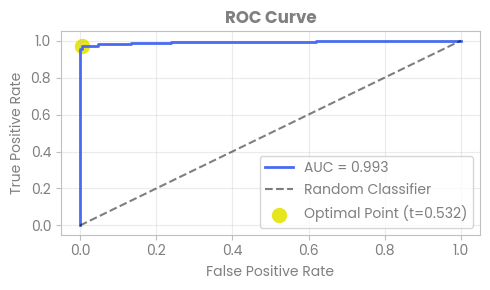

In [230]:
# ROC Curve
plt.figure(figsize=(5, 3))
fpr_final, tpr_final, thresholds_roc = roc_curve(y_test, y_probs)
roc_auc_final = auc(fpr_final, tpr_final)

plt.plot(fpr_final, tpr_final, color='#496af1', linewidth=2, label=f'AUC = {roc_auc_final:.3f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')

optimal_idx = np.argmax(tpr_final - fpr_final)
optimal_threshold_roc = thresholds_roc[optimal_idx]
plt.scatter(fpr_final[optimal_idx], tpr_final[optimal_idx], color='#e6e51e', s=100, label=f'Optimal Point (t={optimal_threshold_roc:.3f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **4.3. Precision-Recall Curve**

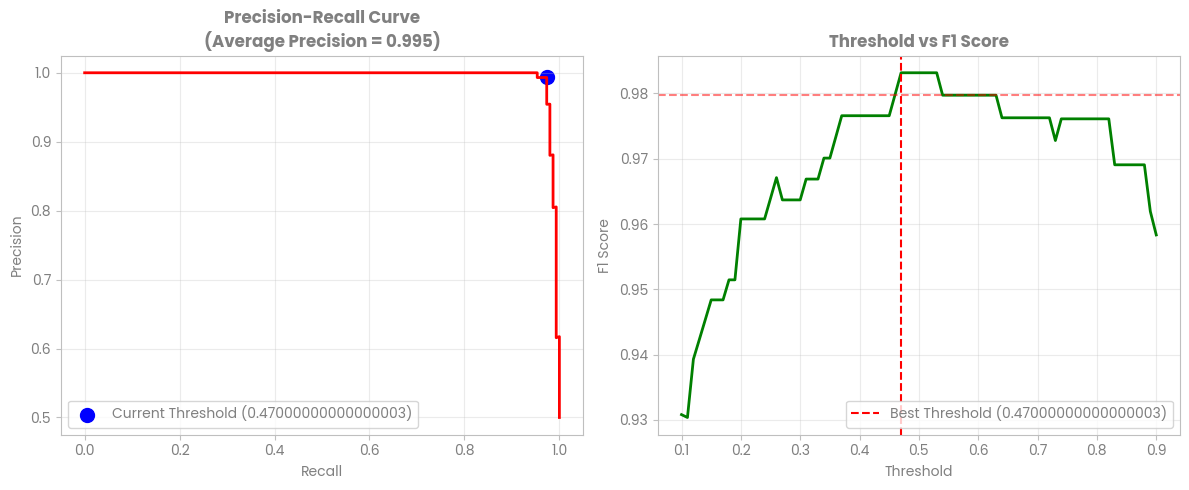

In [231]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='red', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve\n(Average Precision = {avg_precision:.3f})', fontweight='bold')
plt.grid(True, alpha=0.3)

# Mark current threshold
current_precision = precision_score(y_test, y_pred)
current_recall = recall_score(y_test, y_pred)
plt.scatter(current_recall, current_precision, color='blue', s=100, label=f'Current Threshold ({best_threshold})')
plt.legend()

# Threshold vs F1 Score
plt.subplot(1, 2, 2)
f1_scores = []
thresholds_range = np.arange(0.1, 0.91, 0.01)

for thresh in thresholds_range:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

plt.plot(thresholds_range, f1_scores, color='green', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold})')
plt.axhline(y=f1_scores[best_idx], color='red', linestyle='--', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Threshold vs F1 Score', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **4.4. Learning Curves**

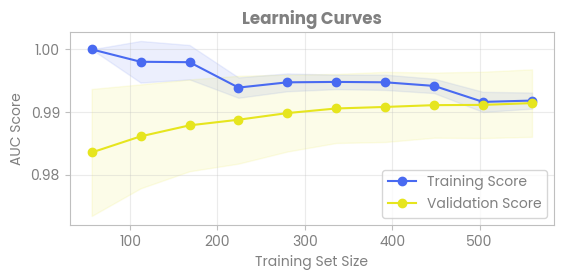

In [232]:
train_sizes, train_scores, val_scores = learning_curve(
    logreg_grid.best_estimator_, X_train_logreg, y_train,
    cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='roc_auc'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(6.25, 2.5))
plt.plot(train_sizes, train_mean, 'o-', color='#496af1', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='#496af1')

plt.plot(train_sizes, val_mean, 'o-', color='#e6e51e', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='#e6e51e')

plt.xlabel('Training Set Size')
plt.ylabel('AUC Score')
plt.title('Learning Curves', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **4.5. Cross Validation**

In [ ]:
# Cross-validation detailed analysis
cv_results = cross_validate(
    logreg_grid.best_estimator_,
    X_train_logreg, y_train,
    cv=5,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    return_train_score=True
)

print("=== CROSS-VALIDATION DETAILED RESULTS ===")
for metric in ['roc_auc', 'f1', 'precision', 'recall']:
    test_scores = cv_results[f'test_{metric}']
    train_scores = cv_results[f'train_{metric}']

    print(f"{metric.upper()}:")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Gap:   {abs(train_scores.mean() - test_scores.mean()):.4f}")
    print()

=== CROSS-VALIDATION DETAILED RESULTS ===
ROC_AUC:
  Test:  0.9909 ± 0.0058
  Train: 0.9916 ± 0.0013
  Gap:   0.0006

F1:
  Test:  0.9511 ± 0.0165
  Train: 0.9586 ± 0.0044
  Gap:   0.0074

PRECISION:
  Test:  0.9794 ± 0.0115
  Train: 0.9849 ± 0.0033
  Gap:   0.0055

RECALL:
  Test:  0.9257 ± 0.0398
  Train: 0.9336 ± 0.0074
  Gap:   0.0079



# **5. Feature Importance Analysis**

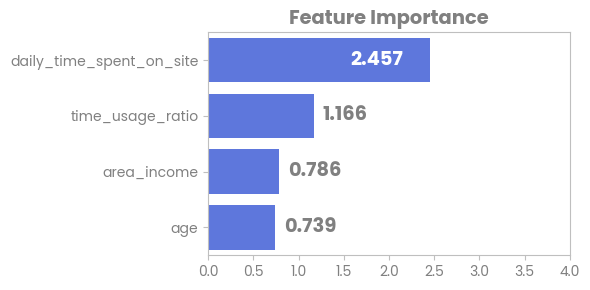

In [ ]:
feature_importance = logreg_grid.best_estimator_.coef_[0]
feature_names = X_train_logreg.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(feature_importance)
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(6, 3))
ax = sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.xlim(0, 4)

for i, p in enumerate(ax.patches):
    value = p.get_width()
    if i == 0:  # bar pertama
        ax.text(value - 0.3, p.get_y() + p.get_height() / 2, f"{value:.3f}", va='center', ha='right', color='white', fontweight='bold', fontsize=14)
    else:
        ax.text(value + 0.1, p.get_y() + p.get_height() / 2, f"{value:.3f}", va='center', ha='left', fontweight='bold', fontsize=14)

plt.title('Feature Importance', fontweight='bold', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

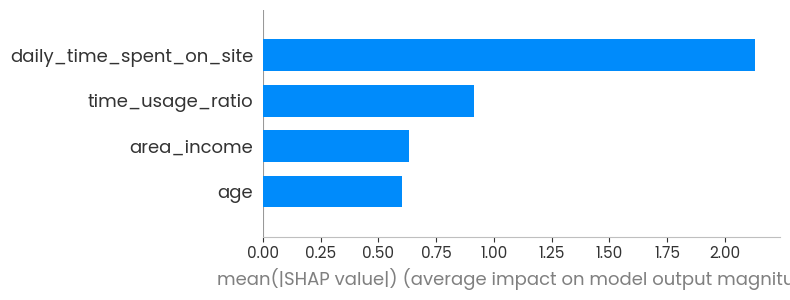

In [ ]:
best_logreg = logreg_grid.best_estimator_
explainer = shap.Explainer(best_logreg, X_train_logreg)
shap_values = explainer(X_train_logreg)
shap.summary_plot(shap_values, X_train_logreg, plot_type="bar")

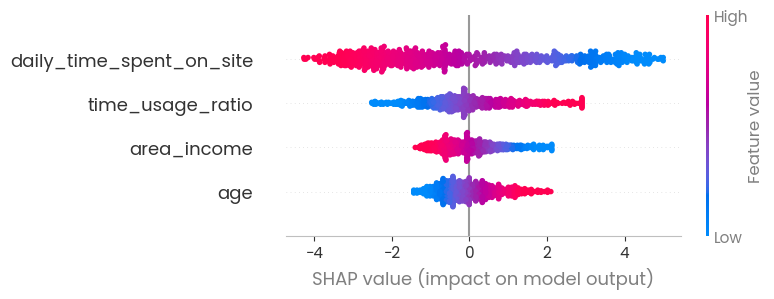

In [ ]:
shap.summary_plot(shap_values, X_train_logreg)
plt.close()

# **6. Prediction Distribution Analysis**

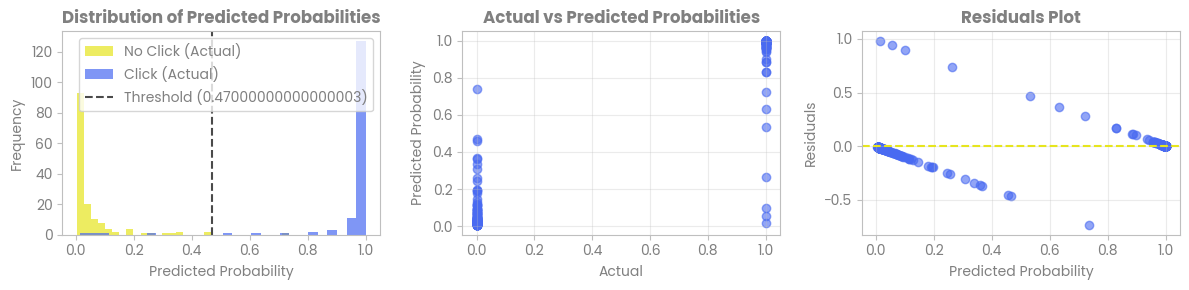

In [233]:
residuals = y_test - y_probs

plt.figure(figsize=(12, 3))

# Distribution of predicted probabilities
plt.subplot(1, 3, 1)
plt.hist(y_probs[y_test == 0], bins=30, alpha=0.7, label='No Click (Actual)', color='#e6e51e')
plt.hist(y_probs[y_test == 1], bins=30, alpha=0.7, label='Click (Actual)', color='#496af1')
plt.axvline(x=best_threshold, color='#4a4a4a', linestyle='--', label=f'Threshold ({best_threshold})')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities', fontweight='bold')
plt.legend()

# Actual vs Predicted scatter plot
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_probs, alpha=0.6)
plt.xlabel('Actual')
plt.ylabel('Predicted Probability')
plt.title('Actual vs Predicted Probabilities', fontweight='bold')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 3, 3)
plt.scatter(y_probs, residuals, alpha=0.6)
plt.axhline(y=0, color='#e6e51e', linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('Residuals')
plt.title('Residuals Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()